In [1]:
import pandas as pd
import random
import time
import math
import os

from mxnet import autograd, np, npx, gluon, init
from mxnet.gluon import loss as gloss
from mxnet.gluon import nn
npx.set_np()

In [2]:
from matplotlib import pyplot as plt

# 定义绘图相关函数
def use_svg_display():
    """Use the svg format to display a plot in Jupyter.""" 
    # display.set_matplotlib_formats('svg')
    
def set_figsize(figsize=(7, 5)):
    """Set the figure size for matplotlib."""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None, ylim=None, 
         xscale='linear', yscale='linear',fmts=('-', 'm--', 'g-.', 'r:'), figsize=(7, 5), axes=None
    ):
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # Return True if X (ndarray or list) has 1 axis
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
    plt.show()

# Saved in the d2l package for later use 
class Timer:
    """Record multiple running times.""" 
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        # Start the timer 
        self.tik = time.time()

    def stop(self):
        # Stop the timer and record the time in a list 
        self.times.append(time.time() - self.tik) 
        return self.times[-1]

    def avg(self):
        # Return the average time 
        return sum(self.times) / len(self.times)

    def sum(self):
        # Return the sum of time 
        return sum(self.times)

    def cumsum(self):
        # Return the accumulated times 
        return np.array(self.times).cumsum().tolist()

#  03. Linear Neural Networks
Before we get into the details of deep neural networks, we need to cover the basics of neural network training. In this chapter, we will cover the entire training process, including defining simple neural network architectures, handling data, specifying a loss function, and training the model. In order to make things easier to grasp, we begin with the simplest concepts. Fortunately, classic statistical learning techniques such as linear and logistic regression can be cast as shallow neural networks. Starting from these classic algorithms, we will introduce you to the basics, providing the basis for more complex techniques such as softmax regression (introduced at the end of this chapter) and multilayer perceptrons (introduced in the next chapter).

## 3.1 Linear Regression
Regression refers to a set of methods for modeling the relationship between data points $\mathbf{x}$ and corresponding real-valued targets $y$. In the natural sciences and social sciences, the purpose of regression is most often to characterize the relationship between the inputs and outputs. Machine learning, on the other hand, is most often concerned with prediction.

Regression problems pop up whenever we want to predict a numerical value. Common examples include predicting prices (of homes, stocks, etc.), predicting length of stay (for patients in the hospital), demand forecasting (for retail sales), among countless others. Not every prediction problem is a classic regression problem. In subsequent sections, we will introduce classification problems, where the goal is to predict membership among a set of categories.

### 3.1.1 Basic Elements of Linear Regression
Linear regression may be both the simplest and most popular among the standard tools to regression. Dating back to the dawn of the 19th century, linear regression flows from a few simple assumptions:
+ First, we assume that the relationship between the features $\mathbf{x}$ and targets $y$ is linear, i.e., that $y$ can be expressed as a weighted sum of the inputs $\textbf{x}$, give or take some noise on the observations. 
+ Second, we assume that any noise is well-behaved (following a Gaussian distribution). 

To motivate the approach, let us start with a running example. Suppose that we wish to estimate the prices of houses (in dollars) based on their area (in square feet) and age (in years).

To actually fit a model for predicting house prices, we would need to get our hands on a dataset consisting of sales for which we know the sale price, area and age for each home. In the terminology of machine learning, the dataset is called a `training data set` or `training set`, and each row (here the data corresponding to one sale) is called an `example` (or `data instance`, `data point`, `sample`). The thing we are trying to predict (here, the price) is called a `label` (or `target`). The variables (here age and area) upon which the predictions are based are called `features` or `covariates`.

Typically, we will use $n$ to denote the number of examples in our dataset. We index the data instances by $i$, denoting each input as $x^{(i)} = [x_1^{(i)}, x_2^{(i)}]$ and the corresponding label as $y^{(i)}$.

##### Linear Model
The linearity assumption just says that the target (price) can be expressed as a weighted sum of the features (area and age):
$$\mathrm{price} = w_{\mathrm{area}} \cdot \mathrm{area} + w_{\mathrm{age}} \cdot \mathrm{age} + b.$$

Here, $w_{\mathrm{area}}$ and $w_{\mathrm{age}}$ are called `weights`, and $b$ is called a `bias` (also called an `offset` or `intercept`). The weights determine the influence of each feature on our prediction and the bias just says what value the predicted price should take when all of the features take value $0$. Even if we will never see any homes with zero area, or that are precisely zero years old, we still need the intercept or else we will limit the expressivity of our linear model.

Given a dataset, our goal is to choose the weights $w$ and bias $b$ such that on average, the predictions made according to our model best fit the true prices observed in the data.

In disciplines where it is common to focus on datasets with just a few features, explicitly expressing models long-form like this is common. In ML, we usually work with high-dimensional datasets, so it is more convenient to employ linear algebra notation. When our inputs consist of $d$ features, we express our prediction $\hat{y}$ as
$$\hat{y} = w_1 \cdot x_1 + ... + w_d \cdot x_d + b.$$

Collecting all features into a vector $\mathbf{x}$ and all weights into a vector $\mathbf{w}$, we can express our model compactly using a dot product:
$$\hat{y} = \mathbf{w}^\top \mathbf{x} + b.$$

Here, the vector $\mathbf{x}$ corresponds to a single data point. We will often find it convenient to refer to our entire dataset via the design matrix $\mathbf{X}$. Here, $\mathbf{X}$ contains one row for every example and one column for every feature.

For a collection of data points $\mathbf{X}$, the predictions $\hat{\mathbf{y}}$ can be expressed via the matrix-vector product:

$${\hat{\mathbf{y}}} = \mathbf{X} \mathbf{w} + b.$$

Given a training dataset $\mathbf{X}$ and corresponding (known) targets $\mathbf{y}$, the goal of linear regression is to find the weight vector $w$ and bias term $b$ that given a new data point $\mathbf{x}_i$, sampled from the same distribution as the training data will (in expectation) predict the target $y_i$ with the lowest error.

Even if we believe that the best model for predicting $y$ given $\mathbf{x}$ is linear, we would not expect to find real-world data where $y_i$ exactly equals $\mathbf{w}^\top \mathbf{x}+b$ for all points ($\mathbf{x}, y)$. For example, whatever instruments we use to observe the features $\mathbf{X}$ and labels $\mathbf{y}$ might suffer small amount of measurement error. Thus, even when we are confident that the underlying relationship is linear, we will incorporate a noise term to account for such errors.

Before we can go about searching for the best parameters $\mathbf{w}$ and $b$, we will need two more things:
+ a quality measure for some given model,
+ a procedure for updating the model to improve its quality.

##### Loss Function
Before we start thinking about how to fit our model, we need to determine a measure of fitness. The `loss function` quantifies the distance between the real and predicted value of the target. The loss will usually be a non-negative number where smaller values are better and perfect predictions incur a loss of $0$. The most popular loss function in regression problems is the sum of squared errors. When our prediction for an example $i$ is $\hat{y}^{(i)}$ and the corresponding true label is $y^{(i)}$, the squared error is given by:
$$l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2.$$

The constant $\frac{1}{2}$ makes no real difference but will prove notationally convenient, cancelling out when we take the derivative of the loss. Since the training dataset is given to us, and thus out of our control, the empirical error is only a function of the model parameters. To make things more concrete, consider the example below where we plot a regression problem for a one-dimensional case as shown in `Fig. 3.1.1`.

<img src="images/03_01.png" style="width:300px;"/>

Note that large differences between estimates $\hat{y}^{(i)}$ and observations $y^{(i)}$ lead to even larger contributions to the loss, due to the quadratic dependence. To measure the quality of a model on the entire dataset, we simply average (or equivalently, sum) the losses on the training set.
$$L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

When training the model, we want to find parameters ($\mathbf{w}^*, b^*$) that minimize the total loss across all training examples:
$$\mathbf{w}^*, b^* = \operatorname*{argmin}_{\mathbf{w}, b}\ L(\mathbf{w}, b).$$

##### Analytic Solution
Linear regression happens to be an unusually simple optimization problem. Unlike most other models that we will encounter in this book, linear regression can be solved analytically by applying a simple formula, yielding a global optimum. To start, we can subsume the bias $b$ into the parameter $\mathbf{w}$ by appending a column to the design matrix consisting of all $1s$. Then our prediction problem is to minimize $||\mathbf{y} - \mathbf{X}\mathbf{w}||$. Because this expression has a quadratic form, it is convex, and so long as the problem is not degenerate (our features are linearly independent), it is strictly convex.

Thus there is just one critical point on the loss surface and it corresponds to the global minimum. Taking the derivative of the loss with respect to $\mathbf{w}$ and setting it equal to $0$ yields the analytic solution:

$$\mathbf{w}^* = (\mathbf X^\top \mathbf X)^{-1}\mathbf X^\top \mathbf{y}.$$

While simple problems like linear regression may admit analytic solutions, you should not get used to such good fortune. Although analytic solutions allow for nice mathematical analysis, the requirement of an analytic solution is so restrictive that it would exclude all of deep learning.

##### Gradient descent
Even in cases where we cannot solve the models analytically, and even when the loss surfaces are high-dimensional and nonconvex, it turns out that we can still train models effectively in practice. Moreover, for many tasks, these difficult-to-optimize models turn out to be so much better that figuring out how to train them ends up being well worth the trouble.

The key technique for optimizing nearly any deep learning model, and which we will call upon throughout this book, consists of iteratively reducing the error by updating the parameters in the direction that incrementally lowers the loss function. This algorithm is called `gradient descent`. On convex loss surfaces, it will eventually converge to a global minimum, and while the same cannot be said for nonconvex surfaces, it will at least lead towards a (hopefully good) local minimum.

The most naive application of gradient descent consists of taking the derivative of the true loss, which is an average of the losses computed on every single example in the dataset. In practice, this can be extremely slow. We must pass over the entire dataset before making a single update. Thus, we will often settle for sampling a random minibatch of examples every time we need to compute the update, a variant called `stochastic gradient descent`.

In each iteration, we first randomly sample a minibatch $\mathcal{B}$ consisting of a fixed number of training examples. We then compute the derivative (gradient) of the average loss on the mini batch with regard to the model parameters. Finally, we multiply the gradient by a predetermined step size $\eta > 0$ and subtract the resulting term from the current parameter values.

We can express the update mathematically as follows ($\partial$ denotes the partial derivative) :
$$(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b).$$

To summarize, steps of the algorithm are the following:
+ we initialize the values of the model parameters, typically at random; 
+ we iteratively sample random batches from the data (many times), updating the parameters in the direction of the negative gradient.

For quadratic losses and linear functions, we can write this out explicitly as follows: Note that $\mathbf{w}$ and $\mathbf{x}$ are vectors. Here, the more elegant vector notation makes the math much more readable than expressing things in terms of coefficients, say $w_1, w_2, \ldots, w_d$.
$$ \begin{aligned} \mathbf{w} &\leftarrow \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{\mathbf{w}} l^{(i)}(\mathbf{w}, b) && = \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right),\\ b &\leftarrow b - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_b l^{(i)}(\mathbf{w}, b) && = b - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right). \end{aligned} $$

In the above equation, $|\mathcal{B}|$ represents the number of examples in each minibatch (the `batch size`) and $\eta$ denotes the `learning rate`. We emphasize that the values of the batch size and learning rate are manually pre-specified and not typically learned through model training. These parameters that are tunable but not updated in the training loop are called `hyper-parameters`. Hyperparameter tuning is the process by which these are chosen, and typically requires that we adjust the hyperparameters based on the results of the inner (training) loop as assessed on a separate validation split of the data.

After training for some predetermined number of iterations (or until some other stopping criteria is met), we record the estimated model parameters, denoted $\hat{\mathbf{w}}, \hat{b}$ (in general the `hat` symbol denotes estimates). Note that even if our function is truly linear and noiseless, these parameters will not be the exact minimizers of the loss because, although the algorithm converges slowly towards a local minimum it cannot achieve it exactly in a finite number of steps.

Linear regression happens to be a convex learning problem, and thus there is only one (global) minimum. However, for more complicated models, like deep networks, the loss surfaces contain many minima. Fortunately, for reasons that are not yet fully understood, deep learning practitioners seldom struggle to find parameters that minimize the loss on training data. The more formidable task is to find parameters that will achieve low loss on data that we have not seen before, a challenge called generalization. We return to these topics throughout the book.

##### Making Predictions with the Learned Model
Given the learned linear regression model $\hat{\mathbf{w}}^\top \mathbf{x} + \hat{b}$, we can now estimate the price of a new house (not contained in the training data) given its area $x_1$ and age (year) $x_2$. Estimating targets given features is commonly called `prediction` and `inference`.

We will try to stick with `prediction` because calling this step `inference`, despite emerging as standard jargon in deep learning, is somewhat of a misnomer. In statistics, `inference` more often denotes estimating parameters based on a dataset. This misuse of terminology is a common source of confusion when deep learning practitioners talk to statisticians.

##### Vectorization for Speed
When training our models, we typically want to process whole minibatches of examples simultaneously. Doing this efficiently requires that we vectorize the calculations and leverage fast linear algebra libraries rather than writing costly for-loops in Python.

To illustrate why this matters so much, we can consider two methods for adding vectors. To start we instantiate two $10000$-dimensional vectors containing all ones. In one method we will loop over the vectors with a Python for loop. In the other method we will rely on a single call to `np`.

In [3]:
n = 10000 
a = np.ones(n) 
b = np.ones(n)

c = np.zeros(n) 
timer = Timer() 
for i in range(n):
    c[i] = a[i] + b[i]
'%.5f sec' % timer.stop()

'4.65701 sec'

In [4]:
timer.start() 
d = a + b 
'%.5f sec' % timer.stop()

'0.00063 sec'

You probably noticed that the second method is dramatically faster than the first. Vectorizing code often yields order-of-magnitude speedups. Moreover, we push more of the math to the library and need not write as many calculations ourselves, reducing the potential for errors.

### 3.1.2 The Normal Distribution and Squared Loss
While you can already get your hands dirty using only the information above, in the following section we can more formally motivate the square loss objective via assumptions about the distribution of noise.

Recall from the above that the squared loss $l(y, \hat{y}) = \frac{1}{2} (y - \hat{y})^2$ has many convenient properties. These include a simple derivative $\partial_{\hat{y}} l(y, \hat{y}) = (\hat{y} - y)$.

As we mentioned earlier, linear regression was invented by Gauss in 1795, who also discovered the normal distribution (also called the Gaussian). It turns out that the connection between the normal distribution and linear regression runs deeper than common parentage. To refresh your memory, the probability density of a normal distribution with mean $\mu$ and variance $\sigma^2$ is given as follows:
$$p(z) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (z - \mu)^2\right).$$

Below we define a Python function to compute the normal distribution.

In [5]:
def normal(z, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2) 
    return p * np.exp(- 0.5 / sigma**2 * (z - mu)**2)

We can now visualize the normal distributions.

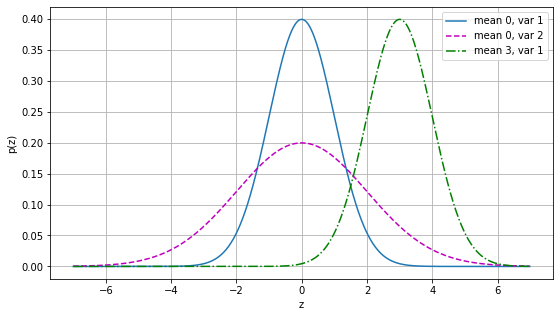

In [6]:
x = np.arange(-7, 7, 0.01)

# Mean and variance pairs 
parameters = [(0, 1), (0, 2), (3, 1)] 
plot(x, [normal(x, mu, sigma) for mu, sigma in parameters], 
    xlabel='z', ylabel='p(z)', figsize=(9, 5), 
    legend=['mean %d, var %d' % (mu, sigma) for mu, sigma in parameters])

As you can see, changing the mean corresponds to a shift along the $x$ axis, and increasing the variance spreads the distribution out, lowering its peak.

One way to motivate linear regression with the mean squared error loss function is to formally assume that observations arise from noisy observations, where the noise is normally distributed as follows
$$y = \mathbf{w}^\top \mathbf{x} + b + \epsilon, \text{where} \epsilon \sim \mathcal{N}(0, \sigma^2).$$

Thus, we can now write out the likelihood of seeing a particular $y$ for a given $\mathbf{x}$ via
$$p(y|\mathbf{x}) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (y - \mathbf{w}^\top \mathbf{x} - b)^2\right).$$

Now, according to the maximum likelihood principle, the best values of $b$ and $\mathbf{w}$ are those that maximize the likelihood of the entire dataset:
$$P(Y\mid X) = \prod_{i=1}^{n} p(y^{(i)}|\mathbf{x}^{(i)}).$$

Estimators chosen according to the maximum likelihood principle are called `Maximum Likelihood Estimators` (`MLE`). While, maximizing the product of many exponential functions, might look difficult, we can simplify things significantly, without changing the objective, by maximizing the log of the likelihood instead. For historical reasons, optimizations are more often expressed as minimization rather than maximization. So, without changing anything we can minimize the `Negative Log-Likelihood` (`NLL`) $-\log p(\mathbf y|\mathbf X)$. Working out the math gives us:
$$-\log p(\mathbf y|\mathbf X) = \sum_{i=1}^n \frac{1}{2} \log(2 \pi \sigma^2) + \frac{1}{2 \sigma^2} \left(y^{(i)} - \mathbf{w}^\top \mathbf{x}^{(i)} - b\right)^2.$$

Now we just need one more assumption: that $\sigma$ is some fixed constant. Thus we can ignore the first term because it does not depend on $\mathbf{w}$ or $b$. Now the second term is identical to the squared error objective introduced earlier, but for the multiplicative constant $\frac{1}{\sigma^2}$. Fortunately, the solution does not depend on $\sigma$. It follows that minimizing squared error is equivalent to maximum likelihood estimation of a linear model under the assumption of additive Gaussian noise.

### 3.1.3 From Linear Regression to Deep Networks
So far we only talked about linear functions. While neural networks cover a much richer family of models, we can begin thinking of the linear model as a neural network by expressing it in the language of neural networks. To begin, let us start by rewriting things in a 'layer' notation.

##### Neural Network Diagram
Deep learning practitioners like to draw diagrams to visualize what is happening in their models. In `Fig. 3.1.2`, we depict our linear model as a neural network. Note that these diagrams indicate the connectivity pattern (here, each input is connected to the output) but not the values taken by the weights or biases.

<img src="images/03_02.png" style="width:400px;"/>

Because there is just a single computed neuron (node) in the graph (the input values are not computed but given), we can think of linear models as neural networks consisting of just a single artificial neuron. Since for this model, every input is connected to every output (in this case there is only one output!), we can regard this transformation as a `fully-connected layer`, also commonly called a `dense layer`. We will talk a lot more about networks composed of such layers in the next chapter on multilayer perceptrons.

##### Biology
Since linear regression (invented in 1795) predates computational neuroscience, it might seem anachronistic to describe linear regression as a neural network. To see why linear models were a natural place to begin when the cyberneticists/neurophysiologists Warren McCulloch and Walter Pitts began to develop models of artificial neurons, consider the cartoonish picture of a biological neuron in `Fig. 3.1.3`, consisting of `dendrites` (input terminals), the `nucleus` (CPU), the `axon` (output wire), and the `axon terminals` (output terminals), enabling connections to other neurons via `synapses`.

<img src="images/03_03.png" style="width:400px;"/>

Information $x_i$ arriving from other neurons (or environmental sensors such as the retina) is received in the dendrites. In particular, that information is weighted by synaptic weights $w_i$ determining the effect of the inputs (e.g., activation or inhibition via the product $x_i w_i$). The weighted inputs arriving from multiple sources are aggregated in the nucleus as a weighted sum $\displaystyle y = \sum_i x_i w_i + b$, and this information is then sent for further processing in the axon $y$, typically after some nonlinear processing via $\sigma(y)$. From there it either reaches its destination (e.g., a muscle) or is fed into another neuron via its dendrites.

Certainly, the high-level idea that many such units could be cobbled together with the right connectivity and right learning algorithm, to produce far more interesting and complex behavior than any one neuron alone could express owes to our study of real biological neural systems.

At the same time, most research in deep learning today draws little direct inspiration in neuroscience. We invoke Stuart Russell and Peter Norvig who, in their classic AI text book `Artificial Intelligence: A Modern Approach`((Russell & Norvig, 2016), pointed out that although airplanes might have been inspired by birds, ornithology has not been the primary driver of aeronautics innovation for some centuries. Likewise, inspiration in deep learning these days comes in equal or greater measure from mathematics, statistics, and computer science.

##### Summary
+ Key ingredients in a machine learning model are training data, a loss function, an optimization algorithm, and quite obviously, the model itself.
+ Vectorizing makes everything better (mostly math) and faster (mostly code).
+ Minimizing an objective function and performing maximum likelihood can mean the same thing.
+ Linear models are neural networks, too.

##### Exercises
1. Assume that we have some data $x_1, \ldots, x_n \in \mathbb{R}$. Our goal is to find a constant $b$ such that $\sum_i (x_i - b)^2$ is minimized.
    + Find a closed-form solution for the optimal value of $b$.
    + How does this problem and its solution relate to the normal distribution?
    
2. Derive the closed-form solution to the optimization problem for linear regression with squared error. To keep things simple, you can omit the bias $b$ from the problem (we can do this in principled fashion by adding one column to $X$ consisting of all ones).
    + Write out the optimization problem in matrix and vector notation (treat all the data as a single matrix, all the target values as a single vector).
    + Compute the gradient of the loss with respect to $w$.
    + Find the closed form solution by setting the gradient equal to zero and solving the matrix equation.
    + When might this be better than using stochastic gradient descent? When might this method break?
    
3. Assume that the noise model governing the additive noise $\epsilon$ is the exponential distribution. That is, $p(\epsilon) = \frac{1}{2} \exp(-|\epsilon|)$.
    + Write out the negative log-likelihood of the data under the model $-\log P(Y \mid X)$.
    + Can you find a closed form solution?
    + Suggest a stochastic gradient descent algorithm to solve this problem. What could possibly go wrong (hint - what happens near the stationary point as we keep on updating the parameters). Can you fix this?

## 3.2 Linear Regression Implementation from Scratch
Now that you understand the key ideas behind linear regression, we can begin to work through a hands-on implementation in code. In this section, we will implement the entire method from scratch, including the data pipeline, the model, the loss function, and the gradient descent optimizer. While modern deep learning frameworks can automate nearly all of this work, implementing things from scratch is the only to make sure that you really know what you are doing. Moreover, when it comes time to customize models, defining our own layers, loss functions, etc., understanding how things work under the hood will prove handy. In this section, we will rely only on `ndarray` and `autograd`. Afterwards, we will introduce a more compact implementation, taking advantage of `Gluon`'s bells and whistles. 

### 3.2.1 Generating the Dataset
To keep things simple, we will construct an artificial dataset according to a linear model with additive noise. Out task will be to recover this model's parameters using the finite set of examples contained in our dataset. We will keep the data low-dimensional so we can visualize it easily. In the following code snippet, we generated a dataset containing $1000$ examples, each consisting of $2$ features sampled from a standard normal distribution. Thus our synthetic dataset will be an object $\mathbf{X}\in \mathbb{R}^{1000 \times 2}$.

The true parameters generating our data will be $\mathbf{w} = [2, -3.4]^\top$ and $b = 4.2$ and our synthetic labels will be assigned according to the following linear model with noise term $\epsilon$:
$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$

You could think of $\epsilon$ as capturing potential measurement errors on the features and labels. We will assume that the standard assumptions hold and thus that $\epsilon$ obeys a normal distribution with mean of $0$. To make our problem easy, we will set its standard deviation to $0.01$. The following code generates our synthetic dataset:

In [7]:
def synthetic_data(w, b, num_examples):
    """Generate y = X w + b + noise."""
    X = np.random.normal(0, 1, (num_examples, len(w)))
    y = np.dot(X, w) + b
    y += np.random.normal(0, 0.01, y.shape)
    return X, y

true_w = np.array([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

Note that each row in features consists of a 2-dimensional data point and that each row in labels consists of a 1-dimensional target value (a scalar).

In [8]:
print('features:', features[0],'\nlabel:', labels[0])

features: [2.2122064 1.1630787] 
label: 4.662078


By generating a scatter plot using the second feature `features[:, 1]` and labels, we can clearly observe the linear correlation between the two.

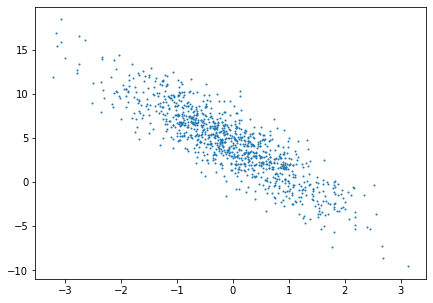

In [9]:
set_figsize((7, 5)) 
plt.scatter(features[:, 1].asnumpy(), labels.asnumpy(), 1)

### 3.2.2 Reading the Dataset
Recall that training models consists of making multiple passes over the dataset, grabbing one minibatch of examples at a time, and using them to update our model. Since this process is so fundamental to training machine learning algorithms, its worth defining a utility function to shuffle the data and access it in minibatches.

In the following code, we define a `data_iter` function to demonstrate one possible implementation of this functionality. The function takes a batch size, a design matrix, and a vector of labels, yielding minibatches of size `batch_size`. Each minibatch consists of a tuple of features and labels.

In [10]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = np.array(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In general, note that we want to use reasonably sized minibatches to take advantage of the GPU hardware, which excels at parallelizing operations. Because each example can be fed through our models in parallel and the gradient of the loss function for each example can also be taken in parallel, GPUs allow us to process hundreds of examples in scarcely more time than it might take to process just a single example.

To build some intuition, let us read and print the first small batch of data examples. The shape of the features in each minibatch tells us both the minibatch size and the number of input features. Likewise, our minibatch of labels will have a shape given by batch_size.

In [11]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y) 
    break

[[-1.1279001   1.5367466 ]
 [ 0.48916838  0.7603386 ]
 [-1.4315921  -0.01926271]
 [-0.6409365   0.9908941 ]
 [ 0.46760127 -0.16282491]
 [ 1.2690786   0.5477537 ]
 [-1.2106425  -1.006717  ]
 [ 0.22596185  0.529344  ]
 [-0.52414197  1.9040878 ]
 [ 1.8919657   0.6615249 ]] 
 [-3.2772422   2.5764859   1.4025525  -0.44816723  5.6876993   4.8570065
  5.2098837   2.8673012  -3.3083458   5.7306504 ]


As we run the iterator, we obtain distinct minibatches successively until all the data has been exhausted (try this). While the iterator implemented above is good for didactic purposes, it is inefficient in ways that might get us in trouble on real problems. For example, it requires that we load all data in memory and that we perform lots of random memory access. The built-in iterators implemented in `Apache MXNet` are considerably more efficient and they can deal both with data stored in file and data fed via a data stream.

### 3.2.3 Initializing Model Parameters
Before we can begin optimizing our model's parameters by gradient descent, we need to have some parameters in the first place. In the following code, we initialize weights by sampling random numbers from a normal distribution with mean 0 and a standard deviation of $0.01$, setting the bias $b$ to $0$.

In [12]:
w = np.random.normal(0, 0.01, (2, 1))
b = np.zeros(1)

After initialized our parameters, our next task is to update them until they fit our data sufficiently well. Each update requires taking the gradient (a multi-dimensional derivative) of our loss function with respect to the parameters. Given this gradient, we can update each parameter in the direction that reduces the loss.

Since nobody wants to compute gradients explicitly (this is tedious and error prone), we use automatic differentiation to compute the gradient. See `Section 2.5` for more details. Recall from the `autograd` chapter that in order for the system to know that it should store a gradient for our parameters, we specified to attach gradients to both $w$ and $b$ on the above codes

In [13]:
w.attach_grad()
b.attach_grad()

### 3.2.4 Defining the Model
Next, we must define our model, relating its inputs and parameters to its outputs. Recall that to calculate the output of the linear model, we simply take the matrix-vector dot product of the examples $\mathbf{X}$ and the models weights $w$, and add the offset $b$ to each example. Note that below $Xw$ is a vector and $b$ is a scalar. Recall that when we add a vector and a scalar, the scalar is added to each component of the vector.

In [14]:
def linreg(X, w, b):
    return np.dot(X, w) + b

### 3.2.5 Defining the Loss Function
Since updating our model requires taking the gradient of our loss function, we ought to define the loss function first. Here we will use the squared loss function as described in the previous section. In the implementation, we need to transform the true value $y$ into the predicted value's shape $\hat{y}$. The result returned by the following function will also be the same as the $\hat{y}$ shape.

In [15]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape))**2/2

### 3.2.6 Defining the Optimization Algorithm
As we discussed in the previous section, linear regression has a closed-form solution. However, this is not a book about linear regression, it is a book about deep learning. Since none of the other models that this book introduces can be solved analytically, we will take this opportunity to introduce your first working example of `stochastic gradient descent` (`SGD`).

At each step, using one batch randomly drawn from our dataset, we will estimate the gradient of the loss with respect to our parameters. Next, we will update our parameters (a small amount) in the direction that reduces the loss. Recall from `Section 2.5` that after we call `backward` each parameter (param) will have its gradient stored in `param.grad`. The following code applies the `SGD` update, given a set of parameters, a learning rate, and a batch size. The size of the update step is determined by the learning rate `lr`. Because our loss is calculated as a sum over the batch of examples, we normalize our step size by the batch size (`batch_size`), so that the magnitude of a typical step size does not depend heavily on our choice of the batch size.

In [16]:
def sgd(params, lr, batch_size):
    for param in params:
        param[:] = param - lr * param.grad / batch_size

### 3.2.7 Training
Now that we have all of the parts in place, we are ready to implement the main training loop. It is crucial that you understand this code because you will see nearly identical training loops over and over again throughout your career in deep learning.

In each iteration, we will grab minibatches of models, first passing them through our model to obtain a set of predictions. After calculating the loss, we call the `backward` function to initiate the backwards pass through the network, storing the gradients with respect to each parameter in its corresponding `.grad` attribute. Finally, we will call the optimization algorithm `sgd` to update the model parameters. Since we previously set the batch size `batch_size` to $10$, the loss shape $l$ for each minibatch is ($10$, $1$).

In summary, we will execute the following loop:
+ Initialize parameters $(\mathbf{w}, b)$
+ Repeat until done
    + Compute gradient $\displaystyle\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{\mathcal{B}} \sum_{i \in \mathcal{B}} l(\mathbf{x}^i, y^i, \mathbf{w}, b)$
    + Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

In the code below, $l$ is a vector of the losses for each example in the minibatch. Because $l$ is not a scalar variable, running `l.backward()` adds together the elements in $l$ to obtain the new variable and then calculates the gradient.

In each epoch (a pass through the data), we will iterate through the entire dataset (using the `data_iter` function) once passing through every examples in the training dataset (assuming the number of examples is divisible by the batch size). The number of epochs `num_epochs` and the learning rate `lr` are both hyper-parameters, which we set here to $3$ and $0.03$, respectively. Unfortunately, setting hyper-parameters is tricky and requires some adjustment by trial and error. We elide these details for now but revise them later in `Chapter 11`.

In [17]:
lr = 0.03  # Learning rate
num_epochs = 3  # Number of iterations
net = linreg  # Our fancy linear model
loss = squared_loss  # 0.5 (y-y')^2

for epoch in range(num_epochs):
    # Assuming the number of examples can be divided by the batch size, all
    # the examples in the training dataset are used once in one epoch
    # iteration. The features and tags of minibatch examples are given by X
    # and y respectively
    for X, y in data_iter(batch_size, features, labels):
        with autograd.record():
            l = loss(net(X, w, b), y)  # Minibatch loss in X and y
        l.backward()  # Compute gradient on l with respect to [w, b]
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    train_l = loss(net(features, w, b), labels)
    print(f'epoch {epoch+1}, loss {float(train_l.mean())}')

epoch 1, loss 0.025138868018984795
epoch 2, loss 8.920243999455124e-05
epoch 3, loss 5.104434603708796e-05


In this case, because we synthesized the data ourselves, we know precisely what the true parameters are. Thus, we can evaluate our success in training by comparing the true parameters with those that we learned through our training loop. Indeed they turn out to be very close to each other.

In [18]:
print('Error in estimating w', true_w - w.reshape(true_w.shape)) 
print('Error in estimating b', true_b - b)

Error in estimating w [ 3.0565262e-04 -3.0755997e-05]
Error in estimating b [0.00037813]


Note that we should not take it for granted that we are able to recover the parameters accurately. This only happens for a special category problems: strongly convex optimization problems with "enough" data to ensure that the noisy samples allow us to recover the underlying dependency. In most cases this is not the case. In fact, the parameters of a deep network are rarely the same (or even close) between two different runs, unless all conditions are identical, including the order in which the data is traversed. However, in machine learning, we are typically less concerned with recovering true underlying parameters, and more concerned with parameters that lead to accurate prediction. Fortunately, even on difficult optimization problems, `stochastic gradient descent` can often find remarkably good solutions, owing partly to the fact that, for deep networks, there exist many configurations of the parameters that lead to accurate prediction.

##### Summary
We saw how a deep network can be implemented and optimized from scratch, using just `ndarray` and auto differentiation, without any need for defining layers, fancy optimizers, etc. This only scratches the surface of what is possible. In the following sections, we will describe additional models based on the concepts that we have just introduced and learn how to implement them more concisely.

##### Exercises
1. What would happen if we were to initialize the weights $\mathbf{w} = 0$. Would the algorithm still work?
2. Assume that you are `Georg Simon Ohm` trying to come up with a model between voltage and current. Can you use auto differentiation to learn the parameters of your model.
3. Can you use `Planck's Law` to determine the temperature of an object using spectral energy density?
4. What are the problems you might encounter if you wanted to compute the second derivatives? How would you fix them?
5. Why is the `reshape` function needed in the `squared_loss` function?
6. Experiment using different learning rates to find out how fast the loss function value drops.
7. If the number of examples cannot be divided by the batch size, what happens to the `data_iter` function's behavior?


## 3.3 Concise Implementation of Linear Regression
Broad and intense interest in deep learning for the past several years has inspired both companies, academics, and hobbyists to develop a variety of mature open source frameworks for automating the repetitive work of implementing gradient-based learning algorithms. 

In the previous section, we relied only on:
+ `ndarray` for data storage and linear algebra
+ auto differentiation for calculating derivatives

In practice, because data iterators, loss functions, optimizers, and neural network layers (and some whole architectures) are so common, modern libraries implement these components for us as well.

In this section, we will show you how to implement the linear regression model from `Section 3.2` concisely by using framework's high-level APIs.

### 3.3.1 Generating the Dataset
To start, we will generate the same dataset as in the previous section.

In [19]:
true_w = np.array([2, -3.4]) 
true_b = 4.2 
features, labels = synthetic_data(true_w, true_b, 1000)

### 3.3.2 Reading the Dataset
Rather than rolling our own iterator, we can call upon the data module to read data:
+ the first step will be to instantiate an `ArrayDataset`. This object's constructor takes one or more `ndarrays` as arguments. Here, we pass in features and labels as arguments
+ next, we will use the `ArrayDataset` to instantiate a `DataLoader`, which also requires that we specify a `batch_size` and specify a `Boolean` value shuffle indicating whether or not we want the `DataLoader` to shuffle the data on each epoch (pass through the dataset)

In [20]:
def load_array(data_arrays, batch_size, is_train=True): 
    """Construct a Gluon data loader."""
    dataset = gluon.data.ArrayDataset(*data_arrays)
    return gluon.data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

Now we can use `data_iter` in much the same way as we called the `data_iter` function in the previous section. To verify that it is working, we can read and print the first minibatch of instances. Comparing to `Section 3.2.2`, here we use iter to construct an Python iterator and then use next to obtain the first item from the iterator.

In [21]:
next(iter(data_iter))

[array([[-0.43901733, -0.1586038 ],
        [ 0.11626463, -0.31604034],
        [ 2.0317695 , -1.0455701 ],
        [ 0.25080684, -1.2058929 ],
        [-1.9351275 ,  0.39395174],
        [ 0.9052883 , -2.0125992 ],
        [ 1.4248887 ,  0.33760387],
        [ 0.2772456 , -0.10989486],
        [-0.05150638,  0.22568646],
        [ 0.76925284,  0.62415916]]),
 array([ 3.8539762,  5.513534 , 11.811262 ,  8.78959  , -1.0148638,
        12.846732 ,  5.90655  ,  5.130535 ,  3.32866  ,  3.6037154])]

### 3.3.3 Defining the Model
When we implemented linear regression from scratch, we defined our model parameters explicitly and coded up the calculations to produce output using basic linear algebra operations. You should know how to do this. But once your models get more complex, and once you have to do this nearly every day, you will be glad for the assistance. The situation is similar to coding up your own blog from scratch. Doing it once or twice is rewarding and instructive, but you would be a lousy web developer if every time you needed a blog you spent a month reinventing the wheel.

For standard operations, we can use the framework's predefined layers, which allow us to focus especially on the layers used to construct the model rather than having to focus on the implementation. To define a linear model, we first import the `nn` module, which defines a large number of neural network layers (note that `nn` is an abbreviation for neural networks). We will first define a model variable `net`, which will refer to an instance of the `Sequential` class. The `Sequential` class defines a container for several layers that will be chained together. Given input data, a `Sequential` passes it through the first layer, in turn passing the output as the second layer's input and so forth. In the following example, our model consists of only one layer, so we do not really need `Sequential`. But since nearly all of our future models will involve multiple layers, we will use it anyway just to familiarize you with the most standard workflow.

Recall the architecture of a single-layer network as shown in `Fig. 3.3.1`. The layer is said to be fully-connected because each of its inputs are connected to each of its outputs by means of a matrix-vector multiplication.

<img src="images/03_04.png" style="width:450px;"/>

In [22]:
net = nn.Sequential()
net.add(nn.Dense(1))

In `Gluon`, the fully-connected layer is defined in the `Dense` class. Since we only want to generate a single scalar output, we set that number to $1$.

It is worth noting that, for convenience, `Gluon` does not require us to specify the input shape for each layer. So here, we do not need to tell `Gluon` how many inputs go into this linear layer. When we first try to pass data through our model, e.g., when we execute `net(X)` later, `Gluon` will automatically infer the number of inputs to each layer. We will describe how this works in more detail in the chapter `Deep Learning Computation`. 

### 3.3.4 Initializing Model Parameters
Before using net, we need to initialize the model parameters, such as the weights and biases in the linear regression model. We will import the initializer module from `MXNet`. This module provides various methods for model parameter initialization. `Gluon` makes init available as a shortcut (abbreviation) to access the initializer package. By calling `init.Normal(sigma=0.01)`, we specify that each weight parameter should be randomly sampled from a normal distribution with mean $0$ and standard deviation $0.01$. The bias parameter will be initialized to zero by default. Both the weight vector and bias will have attached gradients. 

In [23]:
net.initialize(init.Normal(sigma=0.01))

The code above may look straightforward but you should note that something strange is happening here. We are initializing parameters for a network even though `Gluon` does not yet know how many dimensions the input will have! It might be $2$ as in our example or it might be $2000$. `Gluon` lets us get away with this because behind the scenes, the initialization is actually deferred. The real initialization will take place only when we for the first time attempt to pass data through the network. Just be careful to remember that since the parameters have not been initialized yet, we cannot access or manipulate them.

### 3.3.5 Defining the Loss Function
In `Gluon`, the loss module defines various loss functions. We will use the imported module `loss` with the pseudonym `gloss` to avoid confusing it for the variable holding our chosen loss function. In this example, we will use the `Gluon` implementation of squared loss (`L2Loss`).

In [24]:
loss = gloss.L2Loss()

### 3.3.6 Defining the Optimization Algorithm
`Minibatch SGD` and related variants are standard tools for optimizing neural networks and thus `Gluon` supports `SGD` alongside a number of variations on this algorithm through its Trainer class. When we instantiate the Trainer, we will specify the parameters to optimize over (obtainable from our net via `net.collect_params()`), the optimization algorithm we wish to use (sgd), and a dictionary of hyper-parameters required by our optimization algorithm. `SGD` just requires that we set the value `learning_rate`, (here we set it to `0.03`). 

In [25]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.03})
trainer

### 3.3.7 Training
You might have noticed that expressing our model through `Gluon` requires comparatively few lines of code. We did not have to individually allocate parameters, define our loss function, or implement stochastic gradient descent. Once we start working with much more complex models, `Gluon`'s advantages will grow considerably. However, once we have all the basic pieces in place, the training loop itself is strikingly similar to what we did when implementing everything from scratch.

To refresh your memory: for some number of epochs, we will make a complete pass over the dataset (`train_data`), iteratively grabbing one minibatch of inputs and the corresponding ground-truth labels. For each minibatch, we go through the following ritual:
+ Generate predictions by calling `net(X)` and calculate the loss $l$ (the forward pass).
+ Calculate gradients by calling `l.backward()` (the backward pass).
+ Update the model parameters by invoking our `SGD` optimizer (note that trainer already knows which parameters to optimize over, so we just need to pass in the minibatch size.

For good measure, we compute the loss after each epoch and print it to monitor progress.

In [26]:
num_epochs = 3
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        with autograd.record():
            l = loss(net(X), y)
        l.backward()
        trainer.step(batch_size)
    l = loss(net(features), labels)
    print('epoch %d, loss: %f' % (epoch, l.mean().asnumpy()))

epoch 1, loss: 0.042365
epoch 2, loss: 0.000163
epoch 3, loss: 0.000050


Below, we compare the model parameters learned by training on finite data and the actual parameters that generated our dataset. To access parameters with `Gluon`, we first access the layer that we need from net and then access that layer's `weight` and `bias`. To access each parameter's values as an `ndarray`, we invoke its data method. As in our from-scratch implementation, note that our estimated parameters are close to their ground truth counterparts.

In [27]:
w = net[0].weight.data()
print('Error in estimating w', true_w.reshape(w.shape) - w)
b = net[0].bias.data()
print('Error in estimating b', true_b - b)

Error in estimating w [[-0.00021648 -0.00075078]]
Error in estimating b [0.00076628]


##### Summary
+ Using `Gluon`, we can implement models much more succinctly.
+ In `Gluon`, the data module provides tools for data processing, the nn module defines a large number of neural network layers, and the loss module defines many common loss functions.
+ `MXNet`'s module `initializer` provides various methods for model parameter initialization.
+ Dimensionality and storage are automatically inferred (but be careful not to attempt to access parameters before they have been initialized).


##### Exercises
1. If we replace `l = loss(output, y)` with `l = loss(output, y).mean()`, we need to change `trainer.step(batch_size)` to `trainer.step(1)` for the code to behave identically. Why?
2. Review the `MXNet` documentation to see what loss functions and initialization methods are provided in the modules `gluon.loss` and `init`. Replace the `loss` by Huber's loss.
3. How do you access the gradient of `dense.weight`?


## 3.4 Softmax Regression
In `Section 3.1`, we introduced linear regression, working through implementations from scratch in `Section 3.2` and again using `Gluon` in `Section 3.3` to do the heavy lifting.

Regression is the hammer we reach for when we want to answer `how much?` or `how many?` questions. If you want to predict the number of dollars (the price) at which a house will be sold, or the number of wins a baseball team might have, or the number of days that a patient will remain hospitalized before being discharged, then you are probably looking for a regression model.

In practice, we are more often interested in classification: asking not `how much?` but `which one?`
+ Does this email belong in the spam folder or the inbox?
+ Is this customer more likely to sign up or not to sign up for a subscription service?
+ Does this image depict a donkey, a dog, a cat, or a rooster?
+ Which movie is Aston most likely to watch next?

Colloquially, machine learning practitioners overload the word classification to describe two subtly different problems: 
+ those where we are interested only in hard assignments of examples to categories
+ those where we wish to make soft assignments, i.e., to assess the probability that each category applies

The distinction tends to get blurred, in part, because often, even when we only care about hard assignments, we still use models that make soft assignments.

### 3.4.1 Classification Problems
To get our feet wet, let us start off with a simple image classification problem. Here, each input consists of a $2\times2$ grayscale image. We can represent each pixel value with a single scalar, giving us four features $x_1, x_2, x_3, x_4$. Further, let us assume that each image belongs to one among the categories "cat", "chicken" and "dog".

Next, we have to choose how to represent the labels. We have two obvious choices. Perhaps the most natural impulse would be to choose $y \in {1, 2, 3}$, where the integers represent `{dog, cat, chicken}` respectively. This is a great way of storing such information on a computer. If the categories had some natural ordering among them, say if we were trying to predict `{baby, toddler, adolescent, young adult, adult, geriatric}`, then it might even make sense to cast this problem as regression and keep the labels in this format.

But general classification problems do not come with natural orderings among the classes. Fortunately, statisticians long ago invented a simple way to represent categorical data: the one hot encoding. A one-hot encoding is a vector with as many components as we have categories. The component corresponding to particular instance's category is set to 1 and all other components are set to 0.
$$y \in {(1, 0, 0), (0, 1, 0), (0, 0, 1)}.$$

In our case, $y$ would be a three-dimensional vector, with $(1, 0, 0)$ corresponding to "cat", $(0, 1, 0)$ to "chicken" and $(0, 0, 1)$ to "dog".

##### Network Architecture
In order to estimate the conditional probabilities associated with each class, we need a model with multiple outputs, one per class. To address classification with linear models, we will need as many linear functions as we have outputs. Each output will correspond to its own linear function. In our case, since we have 4 features and 3 possible output categories, we will need 12 scalars to represent the weights, ($w$ with subscripts) and 3 scalars to represent the biases ($b$ with subscripts). We compute these three logits, $o_1, o_2$, and $o_3$, for each input:
$$ \begin{aligned} o_1 &= x_1 w_{11} + x_2 w_{12} + x_3 w_{13} + x_4 w_{14} + b_1,\\ o_2 &= x_1 w_{21} + x_2 w_{22} + x_3 w_{23} + x_4 w_{24} + b_2,\\ o_3 &= x_1 w_{31} + x_2 w_{32} + x_3 w_{33} + x_4 w_{34} + b_3. \end{aligned} $$

We can depict this calculation with the neural network diagram shown in `Fig. 3.4.1`. 

<img src="images/03_05.png" style="width:500px;"/>

Just as in linear regression, softmax regression is also a single-layer neural network. And since the calculation of each output, $o_1, o_2$, and $o_3$, depends on all inputs, $x_1$, $x_2$, $x_3$, and $x_4$, the output layer of softmax regression can also be described as fully-connected layer.

To express the model more compactly, we can use linear algebra notation. In vector form, we arrive at $\mathbf{o} = \mathbf{W} \mathbf{x} + \mathbf{b}$, a form better suited both for mathematics, and for writing code. Note that we have gathered all of our weights into a $3\times4$ matrix and that for a given example $\mathbf{x}$, our outputs are given by a matrix-vector product of our weights by our inputs plus our biases $\mathbf{b}$.

##### Softmax Operation
The main approach that we are going to take here is to interpret the outputs of our model as probabilities. We will optimize our parameters to produce probabilities that maximize the likelihood of the observed data. Then, to generate predictions, we will set a threshold, for example, choosing the `argmax` of the predicted probabilities.

Put formally, we would like outputs $\hat{y}_k$ that we can interpret as the probability that a given item belongs to class $k$. Then we can choose the class with the largest output value as our prediction $\mathrm{argmax}_k y_k$. For example, if $\hat{y}_1$, $\hat{y}_2$, and $\hat{y}_3$ are $0.1$, $0.8$, and $0.1$, respectively, then we predict category $2$, which (in our example) represents "chicken".

You might be tempted to suggest that we interpret the logits $o$ directly as our outputs of interest. However, there are some problems with directly interpreting the output of the linear layer as a probability. Nothing constrains these numbers to sum to 1. Moreover, depending on the inputs, they can take negative values. These violate basic axioms of probability presented in `Section 2.6`.

To interpret our outputs as probabilities, we must guarantee that (even on new data), they will be nonnegative and sum up to 1. Moreover, we need a training objective that encourages the model to estimate faithfully probabilities. Of all instances when a classifier outputs $0.5$, we hope that half of those examples will actually belong to the predicted class. This is a property called `calibration`.

The softmax function, invented in 1959 by the social scientist `R Duncan Luce` in the context of choice models does precisely this. To transform our logits such that they become nonnegative and sum to $1$, while requiring that the model remains differentiable, we first exponentiate each logit (ensuring non-negativity) and then divide by their sum (ensuring that they sum to $1$).
$$ \hat{\mathbf{y}} = \mathrm{softmax}(\mathbf{o})\quad \text{where}\quad \hat{y}_i = \frac{\exp(o_i)}{\sum_j \exp(o_j)}. $$

It is easy to see $\hat{y}_1 + \hat{y}_2 + \hat{y}_3 = 1$ with $0 \leq \hat{y}_i \leq 1$ for all $i$. Thus, $\hat{y}$ is a proper probability distribution and the values of $\hat{\mathbf{y}}$ can be interpreted accordingly. Note that the softmax operation does not change the ordering among the logits, and thus we can still pick out the most likely class by:

$$ \hat{\imath}(\mathbf{o}) = \operatorname*{argmax}_i o_i = \operatorname*{argmax}_i \hat y_i. $$

The logits $\mathbf{o}$ then are simply the pre-softmax values that determining the probabilities assigned to each category. Summarizing it all in vector notation we get ${\mathbf{o}}^{(i)} = \mathbf{W} {\mathbf{x}}^{(i)} + {\mathbf{b}}$, where ${\hat{\mathbf{y}}}^{(i)} = \mathrm{softmax}({\mathbf{o}}^{(i)})$.

##### Vectorization for Minibatches
To improve computational efficiency and take advantage of GPUs, we typically carry out vector calculations for minibatches of data. Assume that we are given a minibatch $\mathbf{X}$ of examples with dimensionality $d$ and batch size $n$. Moreover, assume that we have $q$ categories (outputs). Then the minibatch features $\mathbf{X}$ are in $\mathbb{R}^{n \times d}$, weights $\mathbf{W} \in \mathbb{R}^{d \times q}$, and the bias satisfies $\mathbf{b} \in \mathbb{R}^q$.

$$ \begin{aligned} \mathbf{O} &= \mathbf{X} \mathbf{W} + \mathbf{b}, \\ \hat{\mathbf{Y}} & = \mathrm{softmax}(\mathbf{O}). \end{aligned} $$

This accelerates the dominant operation into a matrix-matrix product $\mathbf{W} \mathbf{X}$ vs the matrix-vector products we would be executing if we processed one example at a time. The softmax itself can be computed by exponentiating all entries in $\mathbf{O}$ and then normalizing them by the sum.

### 3.4.2 Loss Function
Next, we need a loss function to measure the quality of our predicted probabilities. We will rely on likelihood maximization, the very same concept that we encountered when providing a probabilistic justification for the least squares objective in linear regression (`Section 3.1`).

##### Log-Likelihood
The softmax function gives us a vector $\hat{\mathbf{y}}$, which we can interpret as estimated conditional probabilities of each class given the input $x$, e.g., $\hat{y}_1$ = $\hat{P}(y=\mathrm{cat} \mid \mathbf{x})$. We can compare the estimates with reality by checking how probable the actual classes are according to our model, given the features.

$$ P(Y \mid X) = \prod_{i=1}^n P(y^{(i)} \mid x^{(i)}) \text{ and thus } -\log P(Y \mid X) = \sum_{i=1}^n -\log P(y^{(i)} \mid x^{(i)}). $$

Maximizing $P(Y \mid X)$ (and thus equivalently minimizing $-\log P(Y \mid X)$) corresponds to predicting the label well. This yields the loss function (we dropped the superscript $(i)$ to avoid notation clutter):

$$ l = -\log P(y \mid x) = - \sum_j y_j \log \hat{y}_j. $$

For reasons explained later on, this loss function is commonly called the `cross-entropy loss`. Here, we used that by construction $\hat{y}$ is a discrete probability distribution and that the vector $\mathbf{y}$ is a one-hot vector. Hence the sum over all coordinates $j$ vanishes for all but one term. Since all $\hat{y}_j$ are probabilities, their logarithm is never larger than $0$. Consequently, the loss function cannot be minimized any further if we correctly predict $y$ with certainty, i.e., if $P(y \mid x) = 1$ for the correct label. Note that this is often not possible. For example, there might be label noise in the dataset (some examples may be mislabeled). It may also not be possible when the input features are not sufficiently informative to classify every example perfectly.

##### Softmax and Derivatives
Since the softmax and the corresponding loss are so common, it is worth while understanding a bit better how it is computed. Plugging $o$ into the definition of the loss $l$ and using the definition of the softmax we obtain:

$$ l = -\sum_j y_j \log \hat{y}_j = \sum_j y_j \log \sum_k \exp(o_k) - \sum_j y_j o_j = \log \sum_k \exp(o_k) - \sum_j y_j o_j. $$

To understand a bit better what is going on, consider the derivative with respect to $o$. We get

$$ \partial_{o_j} l = \frac{\exp(o_j)}{\sum_k \exp(o_k)} - y_j = \mathrm{softmax}(\mathbf{o})_j - y_j = P(y = j \mid x) - y_j. $$

In other words, the gradient is the difference between the probability assigned to the true class by our model, as expressed by the probability $P(y \mid x)$, and what actually happened, as expressed by $y$. In this sense, it is very similar to what we saw in regression, where the gradient was the difference between the observation $y$ and estimate $\hat{y}$. This is not coincidence. In any exponential family model, the gradients of the log-likelihood are given by precisely this term. This fact makes computing gradients easy in practice.

##### Cross-Entropy Loss
Now consider the case where we observe not just a single outcome but an entire distribution over outcomes. We can use the same representation as before for $y$. The only difference is that rather than a vector containing only binary entries, say $(0, 0, 1)$, we now have a generic probability vector, say $(0.1, 0.2, 0.7)$. The math that we used previously to define the loss $l$ still works out fine, just that the interpretation is slightly more general. It is the expected value of the loss for a distribution over labels.

$$ l(\mathbf{y}, \hat{\mathbf{y}}) = - \sum_j y_j \log \hat{y}_j. $$

This loss is called the cross-entropy loss and it is one of the most commonly used losses for multiclass classification. We can demystify the name by introducing the basics of information theory.

### 3.4.3 Information Theory Basics
Information theory deals with the problem of encoding, decoding, transmitting and manipulating information (also known as data) in as concise form as possible.

##### Entropy
The central idea in information theory is to quantify the information content in data. This quantity places a hard limit on our ability to compress the data. In information theory, this quantity is called the entropy of a distribution $p$, and it is captured by the following equation:
$$ H[p] = \sum_j - p(j) \log p(j). $$

One of the fundamental theorems of information theory states that in order to encode data drawn randomly from the distribution $p$, we need at least $H[p]$ "nats" to encode it. If you wonder what a "nat" is, it is the equivalent of bit but when using a code with base $e$ rather than one with base 2. One nat is $\frac{1}{\log(2)} \approx 1.44$ bit. $H[p] / 2$ is often also called the binary entropy.

##### Surprisal
You might be wondering what compression has to do with prediction. Imagine that we have a stream of data that we want to compress. If it is always easy for us to predict the next token, then this data is easy to compress! Take the extreme example where every token in the stream always takes the same value. That is a very boring data stream! And not only it is boring, but it is easy to predict. Because they are always the same, we do not have to transmit any information to communicate the contents of the stream. Easy to predict, easy to compress.

However if we cannot perfectly predict every event, then we might some times be surprised. Our surprise is greater when we assigned an event lower probability. For reasons that we will elaborate in the appendix, Claude Shannon settled on $\log(1/p(j)) = -\log p(j)$ to quantify one's surprisal at observing an event $j$ having assigned it a (subjective) probability $p(j)$. The entropy is then the expected surprisal when one assigned the correct probabilities (that truly match the data-generating process). The entropy of the data is then the least surprised that one can ever be (in expectation).

##### Cross-Entropy Revisited
So if entropy is level of surprise experienced by someone who knows the true probability, then you might be wondering, what is cross-entropy? The cross-entropy from $p$ to $q$, denoted $H(p, q)$, is the expected surprisal of an observer with subjective probabilities $q$ upon seeing data that was actually generated according to probabilities $p$. The lowest possible cross-entropy is achieved when $p=q$. In this case, the cross-entropy from $p$ to $q$ is $H(p, p)= H(p)$. Relating this back to our classification objective, even if we get the best possible predictions, we will never be perfect. Our loss is lower-bounded by the entropy given by the actual conditional distributions $P(\mathbf{y} \mid \mathbf{x})$.

##### Kullback-Leibler Divergence
Perhaps the most common way to measure the distance between two distributions is to calculate the Kullback-Leibler divergence $D(p|q)$. This is simply the difference between the cross-entropy and the entropy, i.e., the additional cross-entropy incurred over the irreducible minimum value it could take:
$$ D(p|q) = H(p, q) - H[p] = \sum_j p(j) \log \frac{p(j)}{q(j)}. $$

Note that in classification, we do not know the true $p$, so we cannot compute the entropy directly. However, because the entropy is out of our control, minimizing $D(p|q)$ with respect to $q$ is equivalent to minimizing the cross-entropy loss.

In short, we can think of the cross-entropy classification objective in two ways: (i) as maximizing the likelihood of the observed data; and (ii) as minimizing our surprise (and thus the number of bits) required to communicate the labels.

##### Model Prediction and Evaluation
After training the softmax regression model, given any example features, we can predict the probability of each output category. Normally, we use the category with the highest predicted probability as the output category. The prediction is correct if it is consistent with the actual category (label). In the next part of the experiment, we will use accuracy to evaluate the model’s performance. This is equal to the ratio between the number of correct predictions and the total number of predictions.

##### Summary
+ We introduced the softmax operation which takes a vector and maps it into probabilities.
+ Softmax regression applies to classification problems. It uses the probability distribution of the output category in the softmax operation.
+ Cross-entropy is a good measure of the difference between two probability distributions. It measures the number of bits needed to encode the data given our model.

##### Exercises
1. Show that the Kullback-Leibler divergence $D(p|q)$ is nonnegative for all distributions $p$ and $q$. Hint: use Jensen's inequality, i.e., use the fact that $-\log x$ is a convex function.
2. Show that $\log \sum_j \exp(o_j)$ is a convex function in $o$.
3. We can explore the connection between exponential families and the softmax in some more depth
    + Compute the second derivative of the cross-entropy loss $l(y,\hat{y})$ for the softmax.
    + Compute the variance of the distribution given by $\mathrm{softmax}(o)$ and show that it matches the second derivative computed above.
4. Assume that we have three classes which occur with equal probability, i.e., the probability vector is $(\frac{1}{3}, \frac{1}{3}, \frac{1}{3})$.
    + What is the problem if we try to design a binary code for it? Can we match the entropy lower bound on the number of bits?
    + Can you design a better code. Hint: what happens if we try to encode two independent observations? What if we encode $n$ observations jointly?
5. Softmax is a misnomer for the mapping introduced above (but everyone in deep learning uses it). The real softmax is defined as $\mathrm{RealSoftMax}(a, b) = \log (\exp(a) + \exp(b))$.
    + Prove that $\mathrm{RealSoftMax}(a, b) > \mathrm{max}(a, b)$.
    + Prove that this holds for $\lambda^{-1} \mathrm{RealSoftMax}(\lambda a, \lambda b)$, provided that $\lambda > 0$.
    + Show that for $\lambda \to \infty$ we have $\lambda^{-1} \mathrm{RealSoftMax}(\lambda a, \lambda b) \to \mathrm{max}(a, b)$.
    + What does the soft-min look like?
    + Extend this to more than two numbers.